### Прогноз модели ARIMA/VAR


Документация по статистическим моделям:
https://www.statsmodels.org/stable/index.html

In [ ]:
import numpy as np
import pandas as pd
from itertools import product

import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.color_palette("pastel")

import warnings
warnings.filterwarnings("ignore")

## Data analysis

In [ ]:
data = pd.read_csv("deposit.csv", sep=";")
data["Date"] = pd.to_datetime(data["Date"], format="%d.%m.%Y")
data.set_index("Date", inplace=True)
data["Deposit_rub"] = (
    data["Deposit_rub"].apply(lambda x: x.replace(",", ".")).astype(float)
)
# data["Deposit_currency"] = (
#     data["Deposit_currency"].apply(lambda x: x.replace(",", ".")).astype(float)
# )

In [ ]:
data.head()

,Deposit_rub,Deposit_currency,Inflation
Date,,,
2014-01-01,14000569.0,"2956962,00","0,34"
2014-02-01,13433121.0,"3256299,00","0,59"
2014-03-01,13510318.0,"3397706,00","0,99"
2014-04-01,13206977.0,"3356873,00","0,88"
2014-05-01,13507416.0,"3340055,00","0,94"


Text(0.5, 0, 'Months')

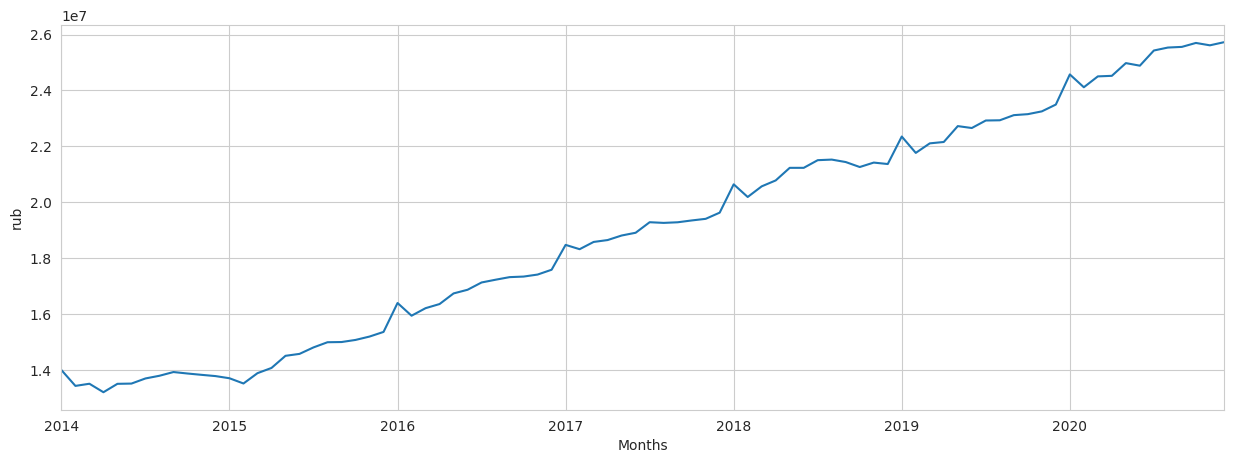

In [ ]:
plt.figure(figsize=(15, 5))
data.Deposit_rub.plot()
plt.ylabel("rub")
plt.xlabel("Months")

In [ ]:
# evaluate components of time-series
# evaluate Dickey-Fuller test for time-series stationarity
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.Deposit_rub)[1])

Dickey-Fuller test: p=0.914995


<Figure size 2000x500 with 0 Axes>

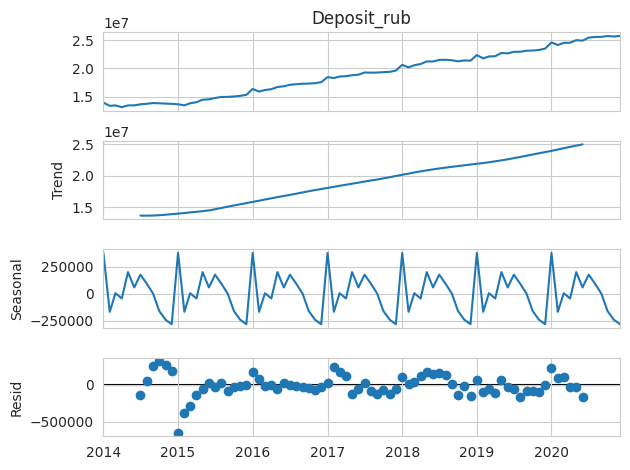

In [ ]:
plt.figure(figsize=(20, 5))
sm.tsa.seasonal_decompose(data.Deposit_rub).plot()
plt.show()

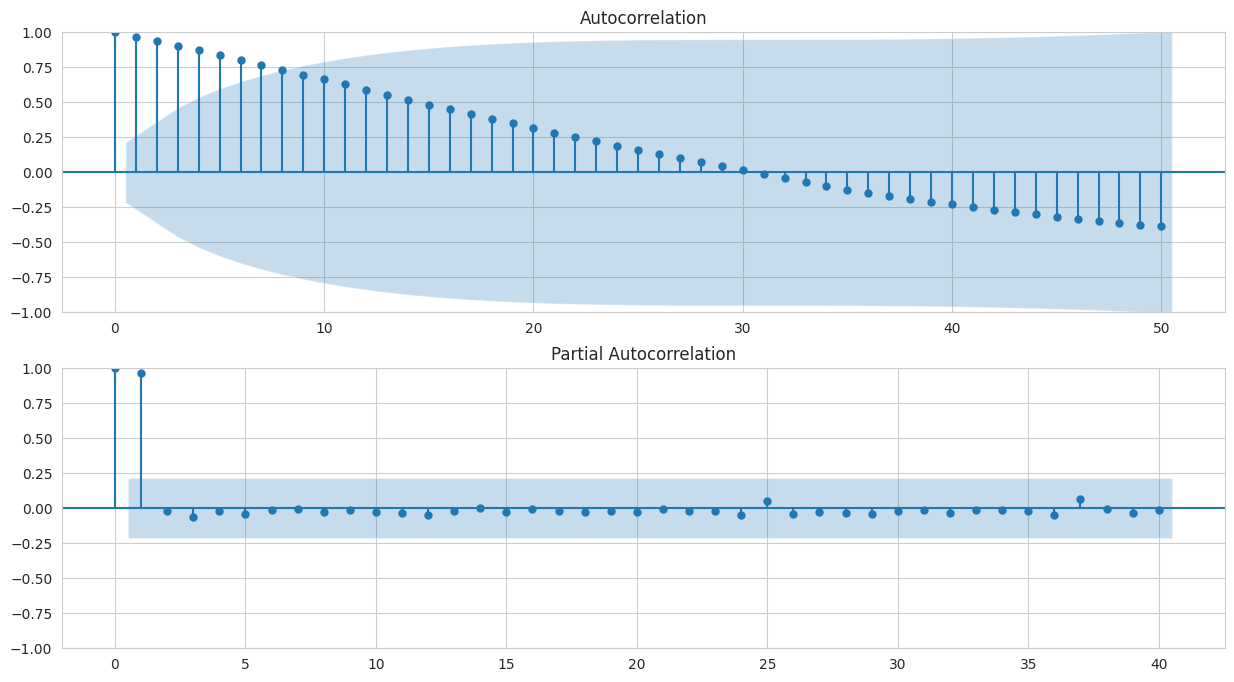

In [ ]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize=(15, 8))

# autocorrelation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.Deposit_rub.values.squeeze(), lags=50, ax=ax)

# partial autocorrelation
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.Deposit_rub.values.squeeze(), lags=40, ax=ax)
plt.show()

Best Box-Cox parameter: 0.408737
Dickey-Fuller test: p=0.368960


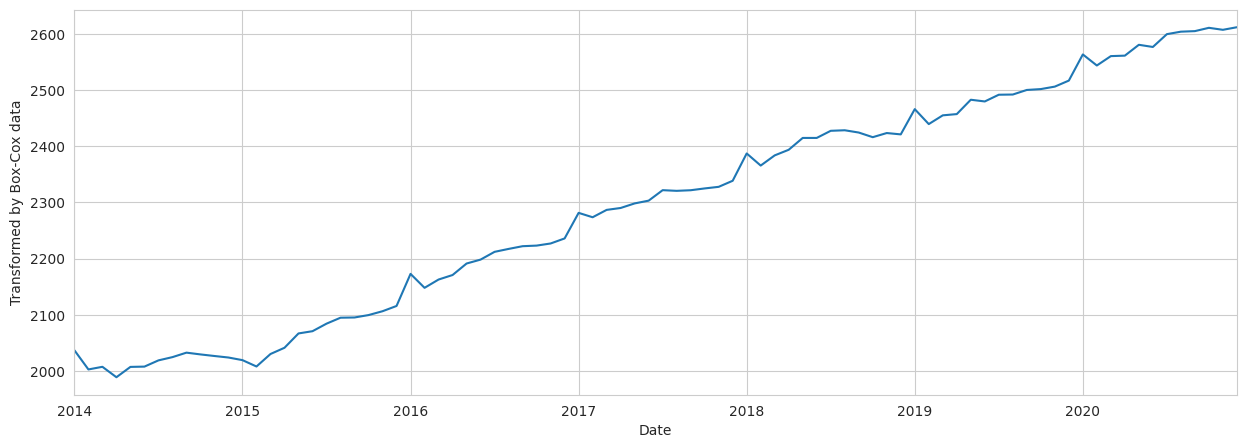

In [ ]:
# Box-Cox transformation for dispersion stationarity

data["deposit_rub_box"], lmbda = stats.boxcox(data.Deposit_rub)
plt.figure(figsize=(15, 5))
data.deposit_rub_box.plot()
plt.ylabel("Transformed by Box-Cox data")
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.deposit_rub_box)[1])

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)

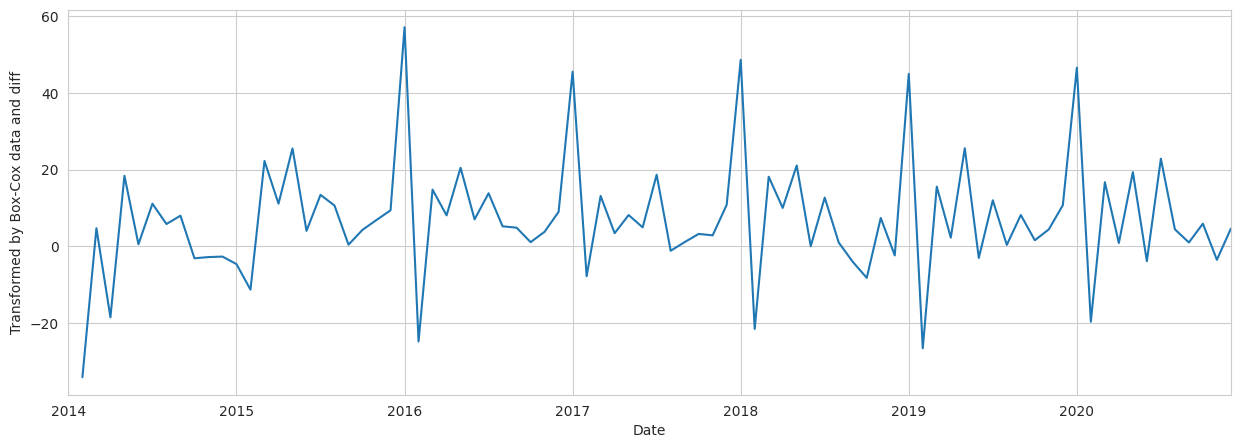

Dickey-Fuller test: p=0.004385


In [ ]:
# difference for 1 months

data["deposit_rub_box_diff"] = data.deposit_rub_box - data.deposit_rub_box.shift(1)
plt.subplots(figsize=(15, 5))
data.deposit_rub_box_diff.plot()
plt.ylabel("Transformed by Box-Cox data and diff")
plt.show()
print(
    "Dickey-Fuller test: p=%f"
    % sm.tsa.stattools.adfuller(data.deposit_rub_box_diff[1:])[1]
)

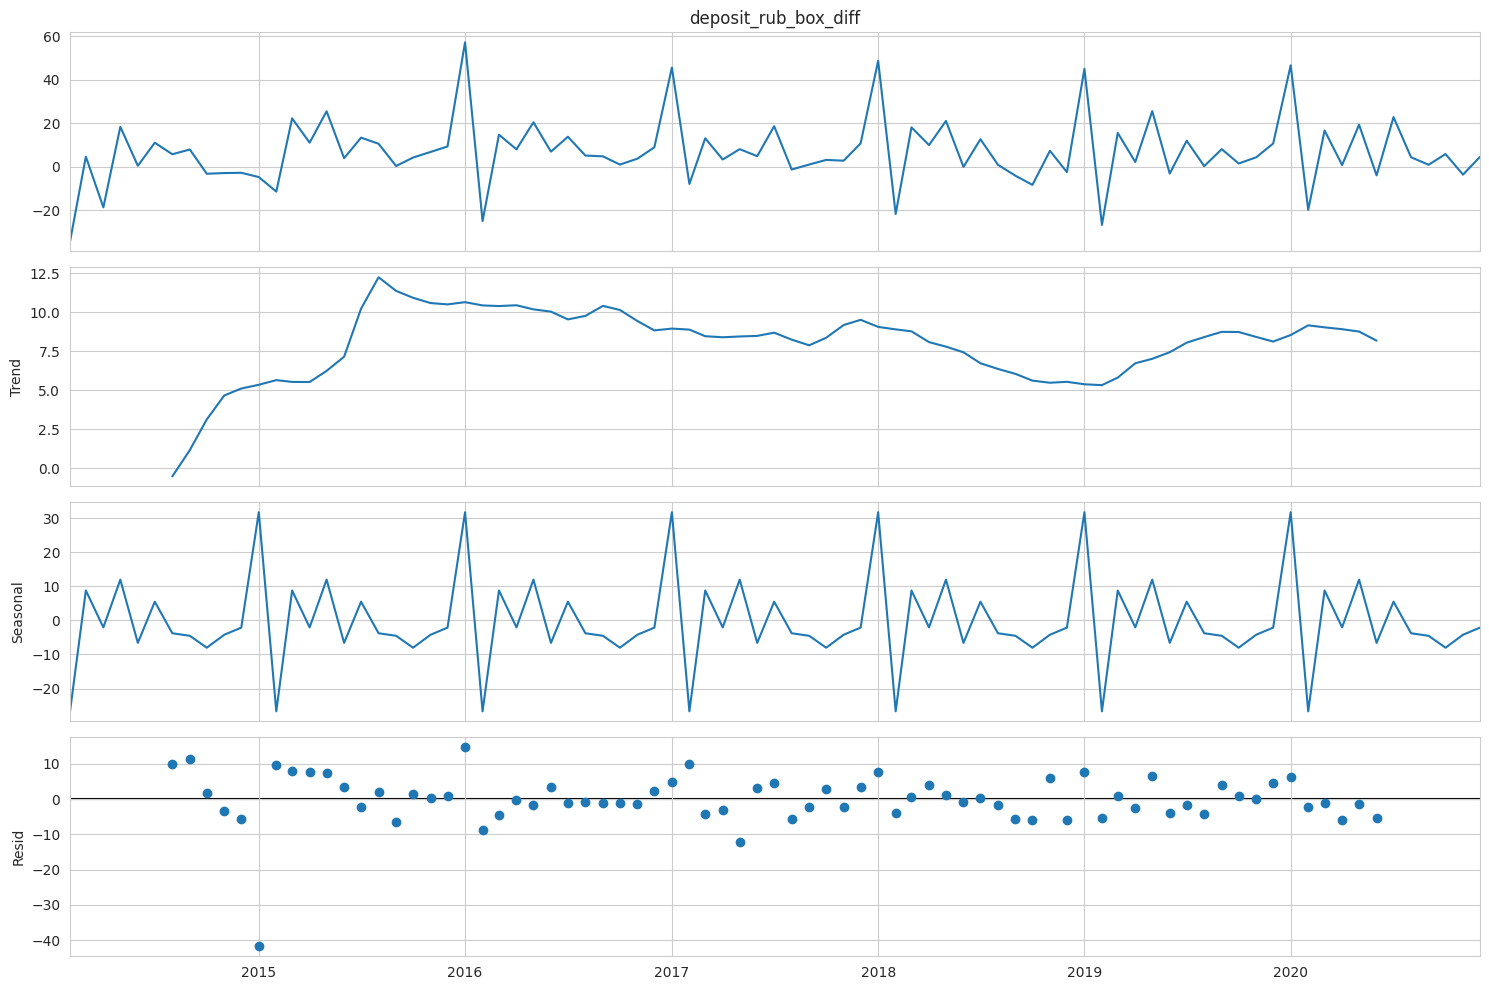

In [ ]:
sm.tsa.seasonal_decompose(data.deposit_rub_box_diff[1:]).plot()
plt.show()

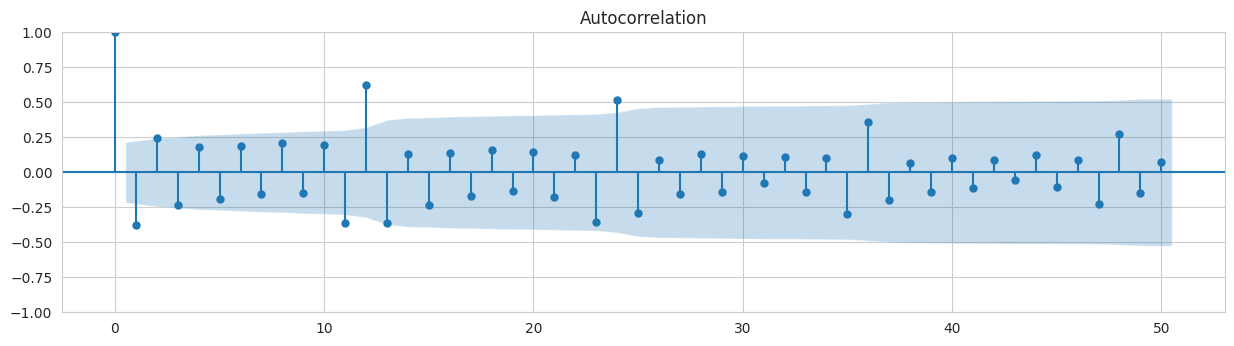

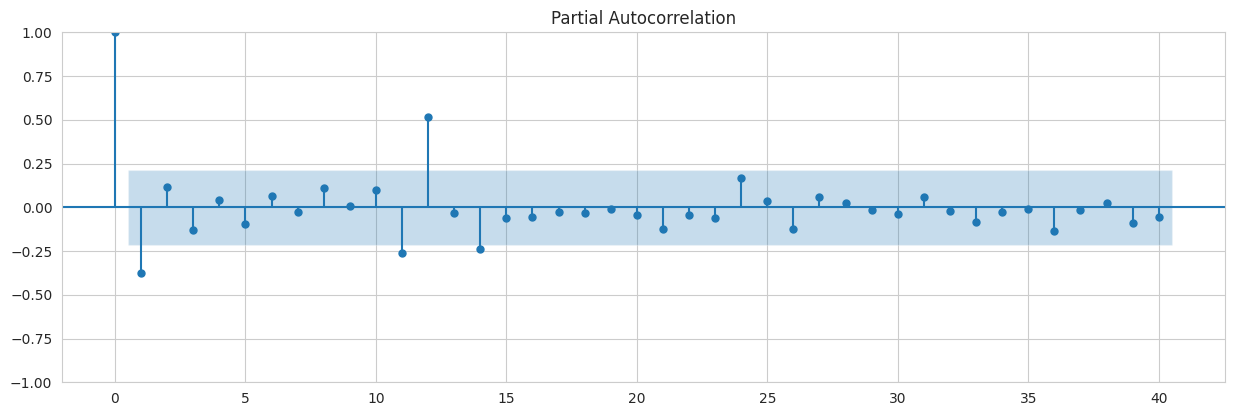

In [ ]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize=(15, 8))

# autocorrelation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.deposit_rub_box_diff[1:].values.squeeze(), lags=50, ax=ax)
plt.show()

# partial autocorrelation
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(
    data.deposit_rub_box_diff[1:].values.squeeze(), lags=40, ax=ax
)

plt.show()

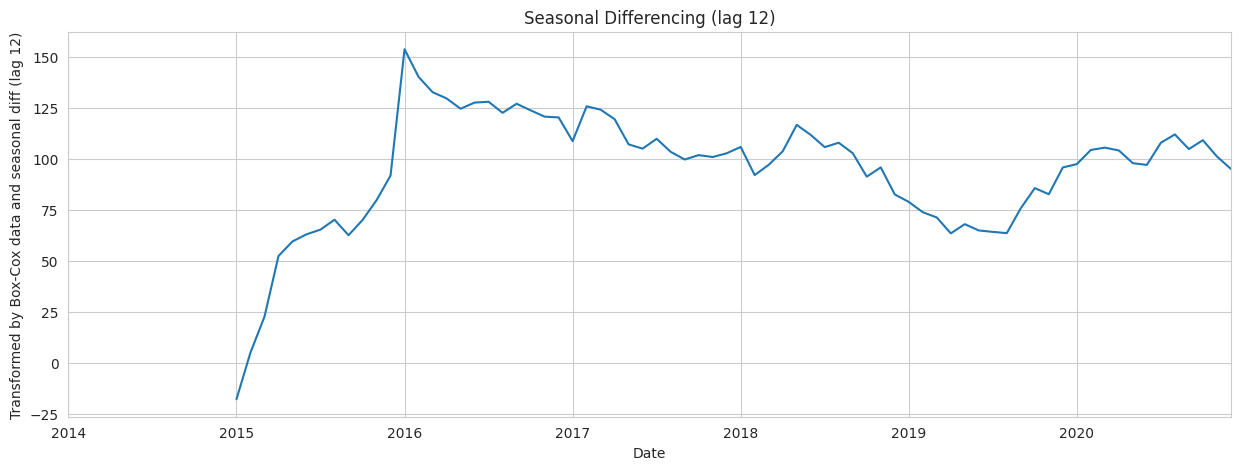

Dickey-Fuller test: p=0.000295
Данные, скорее всего, стационарны (отвергаем H0).
После сезонного дифференцирования ряд стал более стационарным.


In [ ]:
# CODE 1
# seasonal difference for 12 months

# Make additional 12-step difference by analogy with previous cell and evaluate Dickey-Fuller p-value
# Did the data become more stationary?

# Выполняем дифференцирование с лагом в 12 месяцев
data["deposit_rub_box_diff_12"] = data.deposit_rub_box - data.deposit_rub_box.shift(12)

# Строим график дифференцированных данных
plt.subplots(figsize=(15, 5))
data.deposit_rub_box_diff_12.plot()
plt.ylabel("Transformed by Box-Cox data and seasonal diff (lag 12)")
plt.xlabel("Date")
plt.title("Seasonal Differencing (lag 12)")
plt.show()

# Тест Дики-Фуллера на стационарность для сезонно дифференцированных данных
p_value = sm.tsa.stattools.adfuller(data.deposit_rub_box_diff_12.dropna())[1]
print("Dickey-Fuller test: p=%f" % p_value)

# Интерпретация результатов
if p_value < 0.05:
    print("Данные, скорее всего, стационарны (отвергаем H0).")
    print("После сезонного дифференцирования ряд стал более стационарным.")
else:
    print("Данные, скорее всего, нестационарны (не отвергаем H0).")
    print("Ряд не стал более стационарным после сезонного дифференцирования.")



## (S)ARIMA model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
model = ARIMA(data.deposit_rub_box, order=(2, 1, 2))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        deposit_rub_box   No. Observations:                   84
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -335.374
Date:                Mon, 07 Oct 2024   AIC                            680.749
Time:                        10:14:16   BIC                            692.843
Sample:                    01-01-2014   HQIC                           685.607
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0002      0.008      0.019      0.984      -0.016       0.016
ar.L2          0.9998      0.007    137.442      0.000       0.986       1.014
ma.L1         -0.0085      0.484     -0.018      0.986      -0.957       0.940
ma.L2         -0.9906      0.141     -7.047      0.000      -1.266      -0.715
sigma2       175.7502      0.003   5.57e+04      0.000     175.744     175.756
===================================================================================
Ljung-Box (L1) (Q):                   2.60   Jarque-Bera (JB):                12.42
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.51
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.97e+20. Standard errors may be unstable.
"""

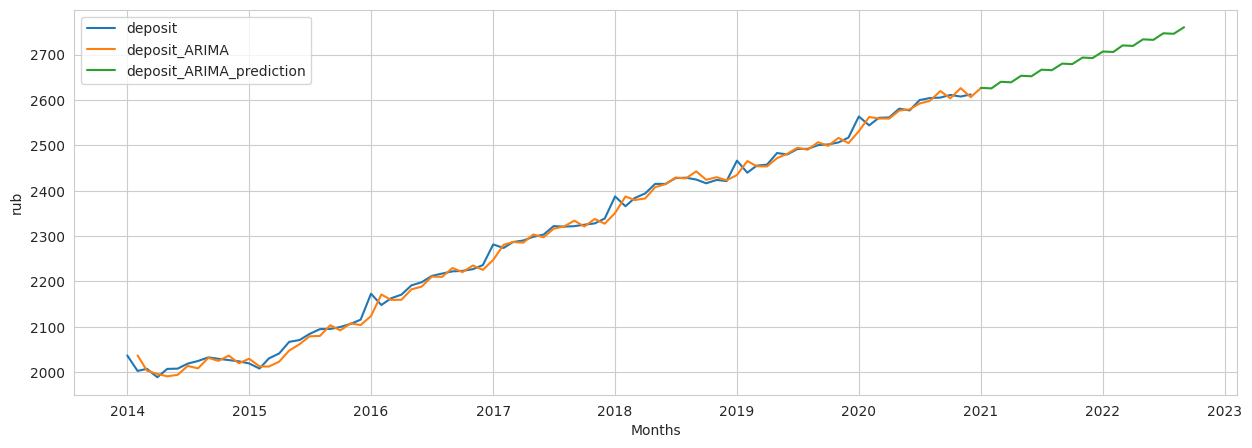

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(data.deposit_rub_box, label="deposit")
plt.plot(res.predict(1, data.shape[0]), label="deposit_ARIMA")
plt.plot(
    res.predict(data.shape[0], data.shape[0] + 20), label="deposit_ARIMA_prediction"
)

plt.legend()
plt.ylabel("rub")
plt.xlabel("Months")
plt.show()

In [ ]:
import statsmodels.api as sm

In [ ]:
res_sarima = sm.tsa.statespace.SARIMAX(
            data.deposit_rub_box,
            order=(3, 1, 4),
            seasonal_order=(2, 1, 3, 12),
        ).fit(disp=-1)

In [ ]:
res_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                            deposit_rub_box   No. Observations:                   84
Model:             SARIMAX(3, 1, 4)x(2, 1, [1, 2, 3], 12)   Log Likelihood                -255.462
Date:                                    Mon, 07 Oct 2024   AIC                            536.924
Time:                                            10:14:24   BIC                            566.339
Sample:                                        01-01-2014   HQIC                           548.622
                                             - 12-01-2020                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3374      0.495     -2.703      0.007      -2.307      -0.368
ar.L2         -1.1138      0.326     -3.413      0.001      -1.753      -0.474
ar.L3         -0.6487      0.332     -1.953      0.051      -1.299       0.002
ma.L1          1.4726      0.519      2.835      0.005       0.455       2.491
ma.L2          1.6394      1.301      1.260      0.208      -0.911       4.190
ma.L3          1.2428      1.332      0.933      0.351      -1.368       3.854
ma.L4          0.2853      0.451      0.633      0.527      -0.599       1.169
ar.S.L12      -0.8297      5.879     -0.141      0.888     -12.353      10.694
ar.S.L24      -0.2967      1.941     -0.153      0.879      -4.101       3.508
ma.S.L12      -0.4566      8.465     -0.054      0.957     -17.047      16.134
ma.S.L24      -0.2603      4.583     -0.057      0.955      -9.243       8.722
ma.S.L36      -0.1915      1.682     -0.114      0.909      -3.488       3.105
sigma2        51.9210    162.813      0.319      0.750    -267.187     371.029
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):               126.37
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                             1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
res_sarima.predict()

,predicted_mean
2014-01-01,0.000000
2014-02-01,2036.728536
2014-03-01,2002.533979
2014-04-01,2007.204007
2014-05-01,1988.622654
...,...
2020-08-01,2600.090438
2020-09-01,2608.760062
2020-10-01,2606.590601
2020-11-01,2613.957894


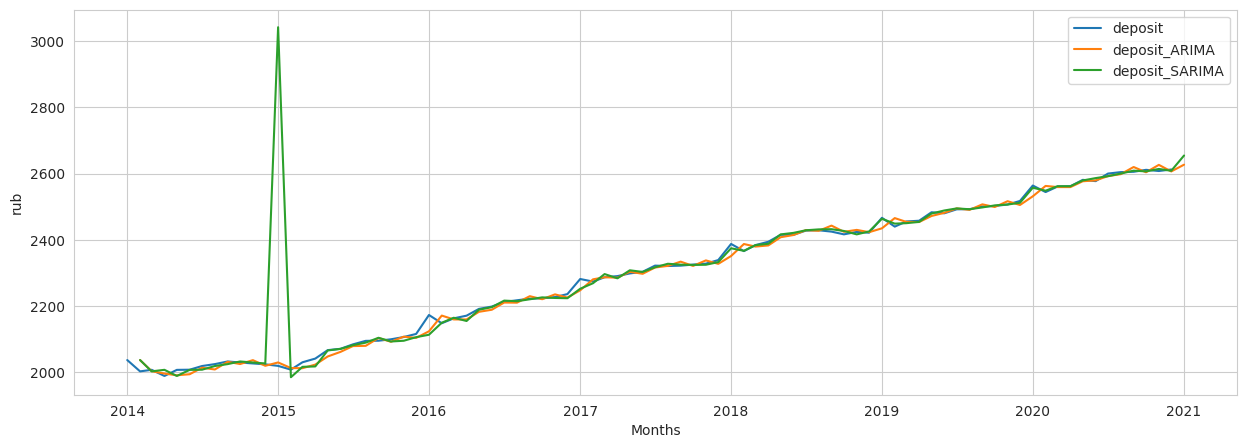

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(data.deposit_rub_box, label="deposit")
plt.plot(res.predict(1, data.shape[0]), label="deposit_ARIMA")
plt.plot(res_sarima.predict(1, data.shape[0]), label="deposit_SARIMA")



plt.legend()
plt.ylabel("rub")
plt.xlabel("Months")
plt.show()

In [ ]:
# CODE 2
# Choose parameters for SARIMA model based on Autocorrelation and Partial Autocorrelation graphs

ps = range(0, 2)
d  = 1
qs = range(0, 2)
Ps = range(0, 2)
D  = 1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print("Number of analysed models:", len(parameters_list))

Number of analysed models: 16


In [ ]:
# here we will choose the best model
results = []
best_aic = float("inf")


for param in parameters_list:

    # try except for the case of wrong parameters
    try:
        model = sm.tsa.statespace.SARIMAX(
            data.deposit_rub_box,
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 12),
        ).fit(disp=-1)

    # print wrong parameters and go on
    # AIC criteria:
    except ValueError:
        print("wrong parameters:", param)
        continue
    aic = model.aic

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])

In [ ]:
# Top models
result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]
print(result_table.sort_values(by="aic", ascending=True).head())

     parameters         aic
2  (0, 0, 1, 1)  528.222585
1  (0, 0, 0, 1)  528.244955
0  (0, 0, 0, 0)  546.006513


In [ ]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                      deposit_rub_box   No. Observations:                   84
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -261.111
Date:                              Mon, 07 Oct 2024   AIC                            528.223
Time:                                      10:14:33   BIC                            535.011
Sample:                                  01-01-2014   HQIC                           530.922
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2960      0.091     -3.256      0.001      -0.474      -0.118
ma.S.L12      -0.99

In [ ]:
# inverse Box-Cox transformation:


def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)


data["model"] = invboxcox(best_model.fittedvalues, lmbda)

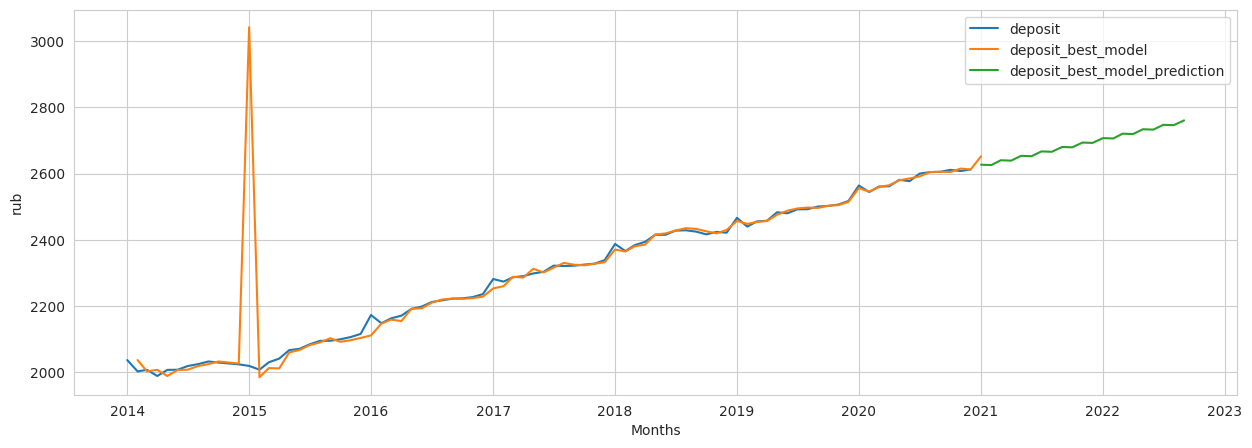

In [ ]:
# CODE 3
# Plot the best model and original time series on the same figure
plt.figure(figsize=(15, 5))
plt.plot(data.deposit_rub_box, label="deposit")
plt.plot(best_model.predict(1, data.shape[0]), label="deposit_best_model")
plt.plot(
    res.predict(data.shape[0], data.shape[0] + 20), label="deposit_best_model_prediction"
)

plt.legend()
plt.ylabel("rub")
plt.xlabel("Months")
plt.show()



In [ ]:
# CODE 4
# Evaluate any metric to check  best model's performance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Получение предсказанных значений на тренировочных данных
predictions = best_model.fittedvalues

# Получение истинных значений
true_values = data['deposit_rub_box']

# Расчет метрик
mae = mean_absolute_error(true_values, predictions)
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 43.57937071202715
Mean Squared Error (MSE): 61973.865236990634
Root Mean Squared Error (RMSE): 248.94550656115615


## Additional Time Series

level of inflation

In [ ]:
data["Inflation"] = data["Inflation"].apply(lambda x: x.replace(",", ".")).astype(float)

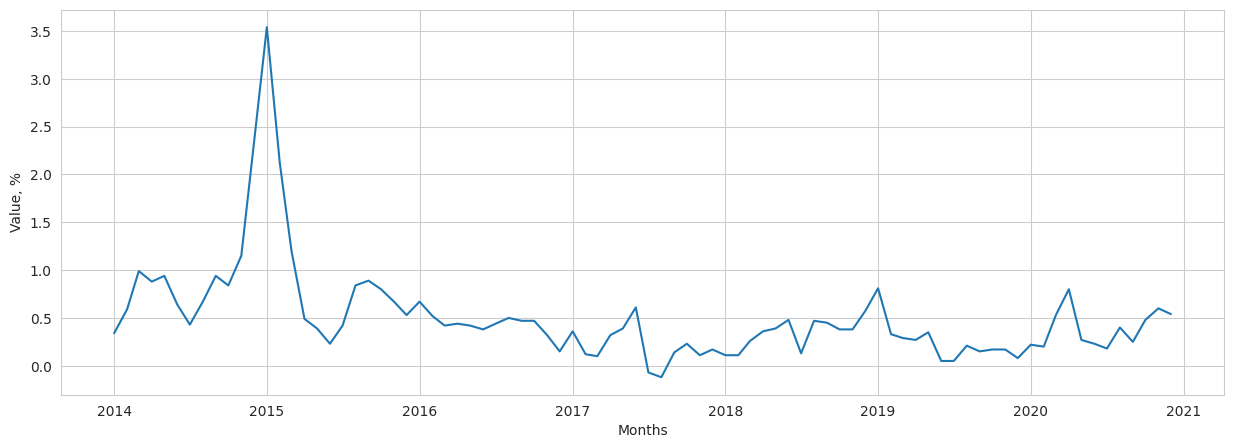

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(data.Inflation)
plt.ylabel("Value, %")
plt.xlabel("Months")
plt.show()

In [ ]:
# data.head()

usd rate

In [ ]:
usd = pd.read_csv("usdrub.csv", sep=";")
usd["Date"] = pd.to_datetime(usd["Date"], format="%d.%m.%Y")
usd["USDRUB"] = usd["USDRUB"].apply(lambda x: x.replace(",", ".")).astype(float)

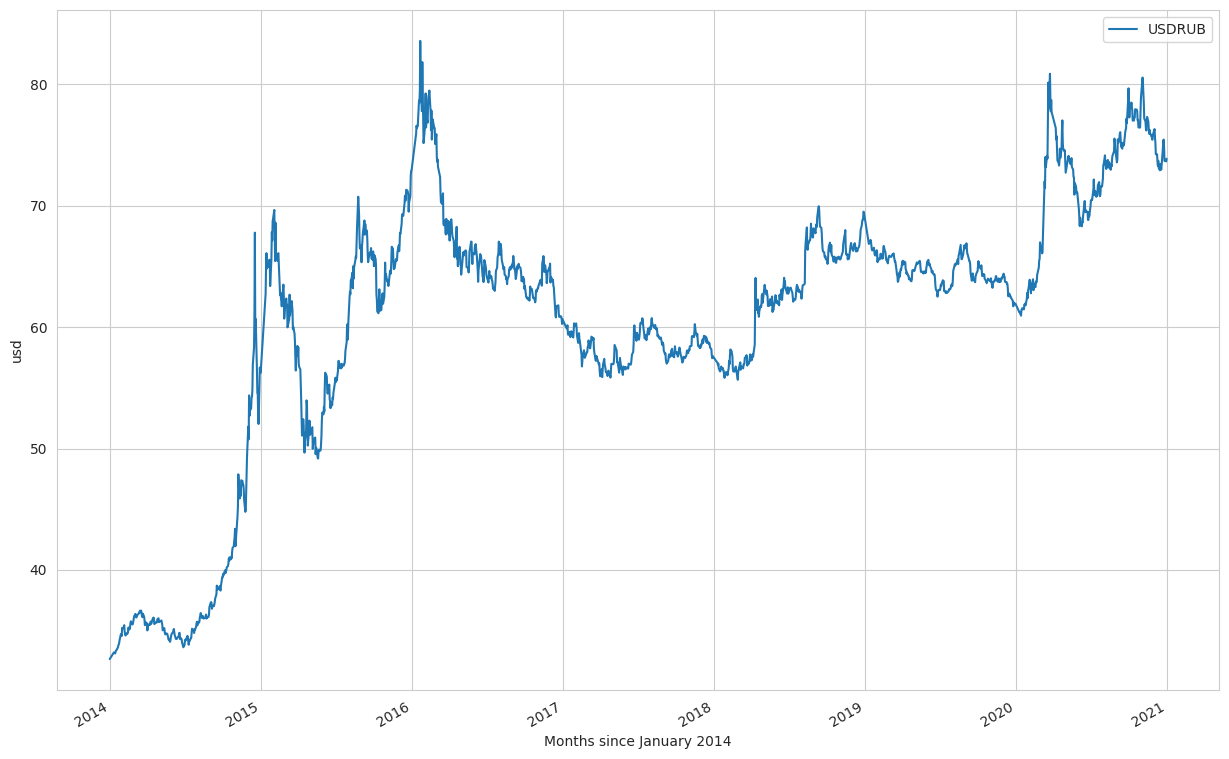

In [ ]:
usd.set_index("Date").plot()
plt.ylabel("usd")
plt.xlabel("Months since January 2014")
plt.show()

In [ ]:
import datetime

In [ ]:
usd["Month"] = usd["Date"].apply(lambda x: datetime.datetime(x.year, x.month, 1))
usd = usd.groupby("Month")["USDRUB"].mean().to_frame()

<Figure size 1500x500 with 0 Axes>

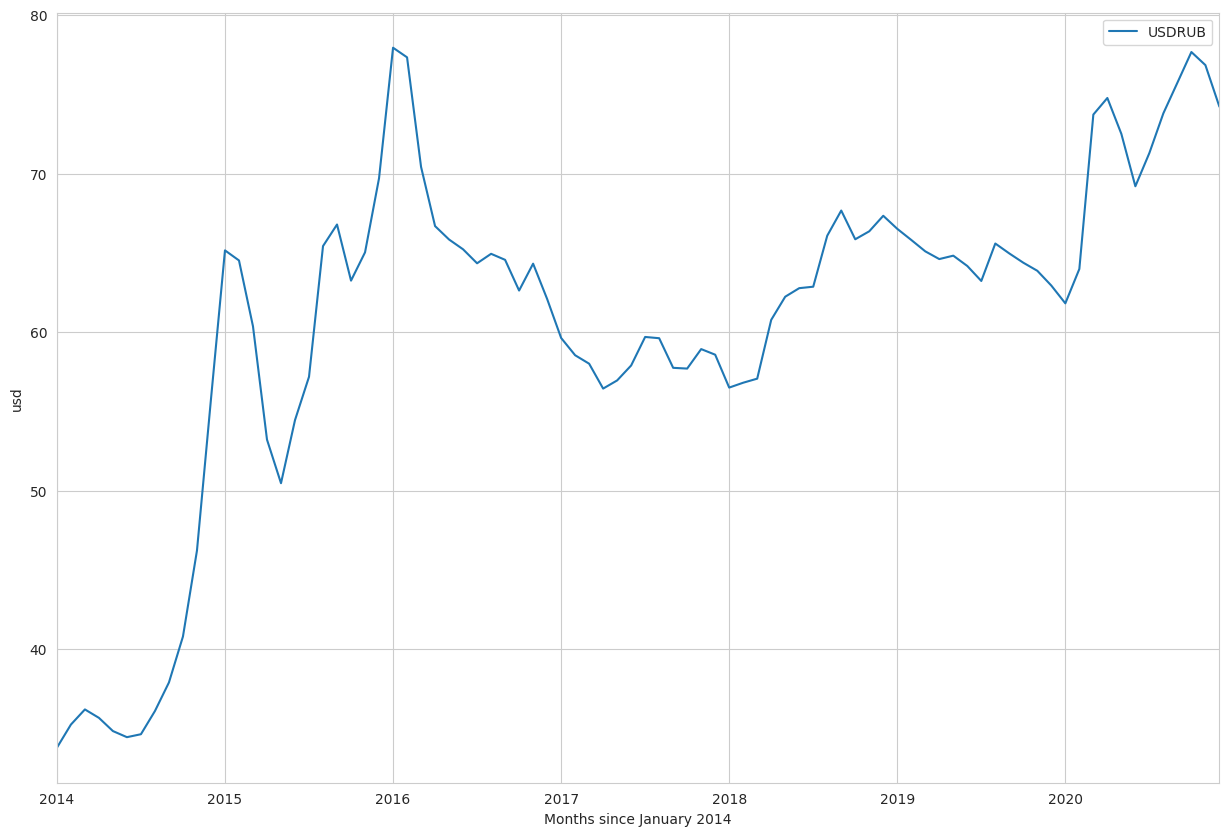

In [ ]:
plt.figure(figsize=(15,5))
usd.plot()
plt.ylabel("usd")
plt.xlabel("Months since January 2014")
plt.show()

In [ ]:
# https://rosstat.gov.ru/labor_market_employment_salaries
data_wage = pd.read_csv("wage.csv", sep=";")
data_wage["date"] = pd.to_datetime(data_wage["date"], format="%d.%m.%Y")
data_wage.set_index("date", inplace=True)

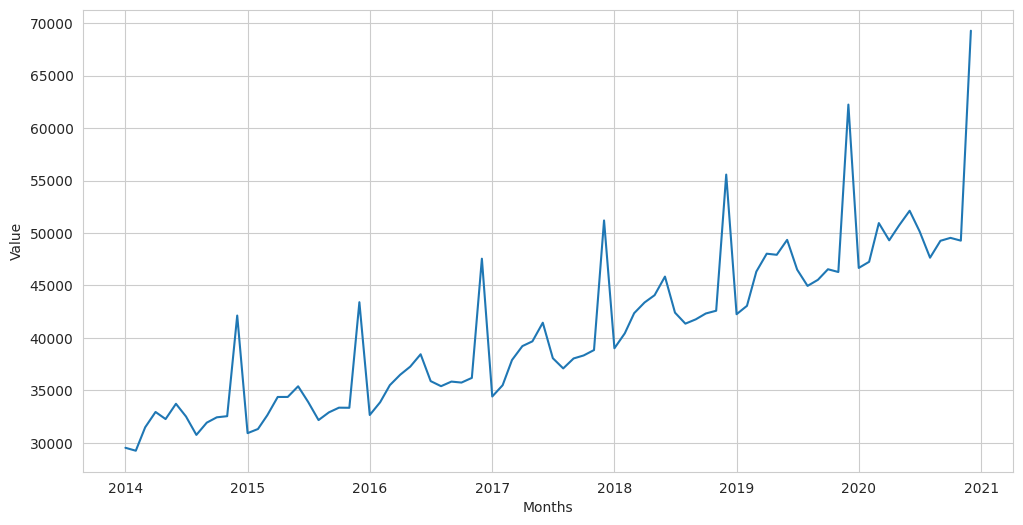

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data_wage.wage)
plt.ylabel("Value")
plt.xlabel("Months")
plt.show()

In [ ]:
def CrossCorr(datax, datay, maxlag=12):
    corr = dict()
    dy = pd.Series(datay)
    for i in range(1, maxlag):
        c = abs(datax.corr(dy.shift(i), method="spearman"))
        corr[i] = c
    return corr

In [ ]:
CrossCorr(data.Deposit_rub, usd.USDRUB)

{1: 0.5735275597162167,
 2: 0.5649372557982608,
 3: 0.5507678410117435,
 4: 0.5425222691045476,
 5: 0.5295034079844206,
 6: 0.5075304442393049,
 7: 0.4973973395026026,
 8: 0.48429254955570744,
 9: 0.46881934566145084,
 10: 0.4503961495742317,
 11: 0.45896581513019874}

In [ ]:
CrossCorr(data.Deposit_rub, data.Inflation)

{1: 0.5484949621388631,
 2: 0.5803645944103593,
 3: 0.6008651723693677,
 4: 0.5965837998356807,
 5: 0.6074094112489161,
 6: 0.6098307786798793,
 7: 0.6031831797128332,
 8: 0.6035881020327934,
 9: 0.6406237994326204,
 10: 0.6731894709509715,
 11: 0.6683949274886994}

In [ ]:
CrossCorr(data.Deposit_rub, data_wage.wage)

{1: 0.9150959237647454,
 2: 0.9020907478151087,
 3: 0.9068879855465221,
 4: 0.905672761368964,
 5: 0.9052823758519962,
 6: 0.9007827615422552,
 7: 0.9042536410957464,
 8: 0.8962132604237867,
 9: 0.8922332859174964,
 10: 0.88584968530174,
 11: 0.8840861409354561}

In [ ]:
import statsmodels.api as sm

In [ ]:
# GrangerTest
x = pd.DataFrame()
x["res"] = data.Deposit_rub
x["cause"] = usd.USDRUB
gr_test = sm.tsa.stattools.grangercausalitytests(x, maxlag=12, verbose=False)
p1=min([gr_test[j][0]['ssr_ftest'][1] for j in gr_test])
print(p1)
# gr_test

0.00040085914546361033


## VAR model

In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
data_var = pd.concat(
    [data.Deposit_rub, data.Inflation, usd.USDRUB, data_wage.wage], axis=1
)

In [ ]:
data_var

,Deposit_rub,Inflation,USDRUB,wage
2014-01-01,14000569.00,0.34,33.784118,29535
2014-02-01,13433121.00,0.59,35.244500,29255
2014-03-01,13510318.00,0.99,36.199000,31486
2014-04-01,13206977.00,0.88,35.667727,32947
2014-05-01,13507416.00,0.94,34.834500,32272
...,...,...,...,...
2020-08-01,25534027.52,0.40,73.799524,47649
2020-09-01,25557608.90,0.25,75.726818,49259
2020-10-01,25699001.52,0.48,77.663478,49539
2020-11-01,25613765.36,0.60,76.838947,49274


In [ ]:
for i in [1, 2, 3, 4, 5]:
    model = VAR(data_var)
    results = model.fit(i)
    print("Order =", i)
    print("AIC: ", results.aic)
#     print("BIC: ", results.bic)
    print()

Order = 1
AIC:  40.57043900897077

Order = 2
AIC:  39.587288824088816

Order = 3
AIC:  39.680690162298376

Order = 4
AIC:  39.68459458589596

Order = 5
AIC:  39.62809212844388



In [ ]:
results = model.fit(5)
# results.summary()

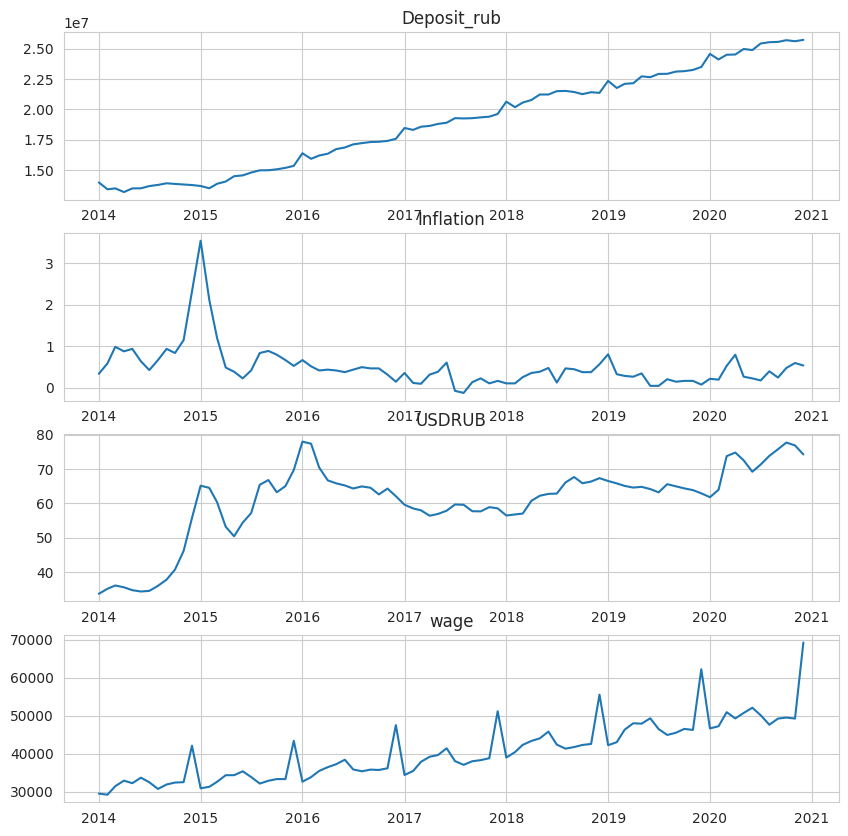

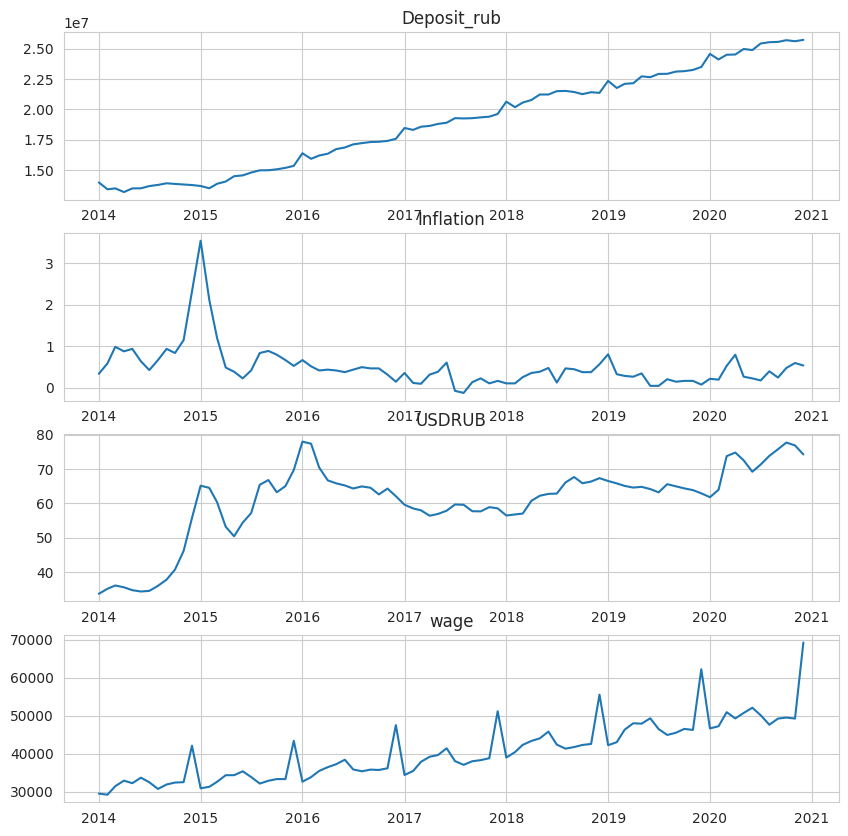

In [ ]:
results.plot()

In [ ]:
results.forecast(data_var.values, 5)

array([[ 2.69865214e+07,  6.47464585e-01,  7.44379273e+01,
         5.05560929e+04],
       [ 2.65776116e+07,  1.27379205e-02,  7.51679608e+01,
         5.21799571e+04],
       [ 2.71185165e+07,  2.03610690e-02,  7.62802156e+01,
         5.27204454e+04],
       [ 2.70288345e+07,  3.68121705e-02,  7.45240319e+01,
         4.90252891e+04],
       [ 2.72516749e+07, -3.61696755e-02,  7.39167498e+01,
         5.38459396e+04]])

ARIMA RMSE (Box-Cox): 21.356219215840106
SARIMA RMSE (Box-Cox): 10.441261606408407
VAR RMSE (Box-Cox): 33.548679623738806
ARIMA RMSE: 503275.8577561485
SARIMA RMSE: 246997.17849000046
VAR RMSE: 789625.0569468475


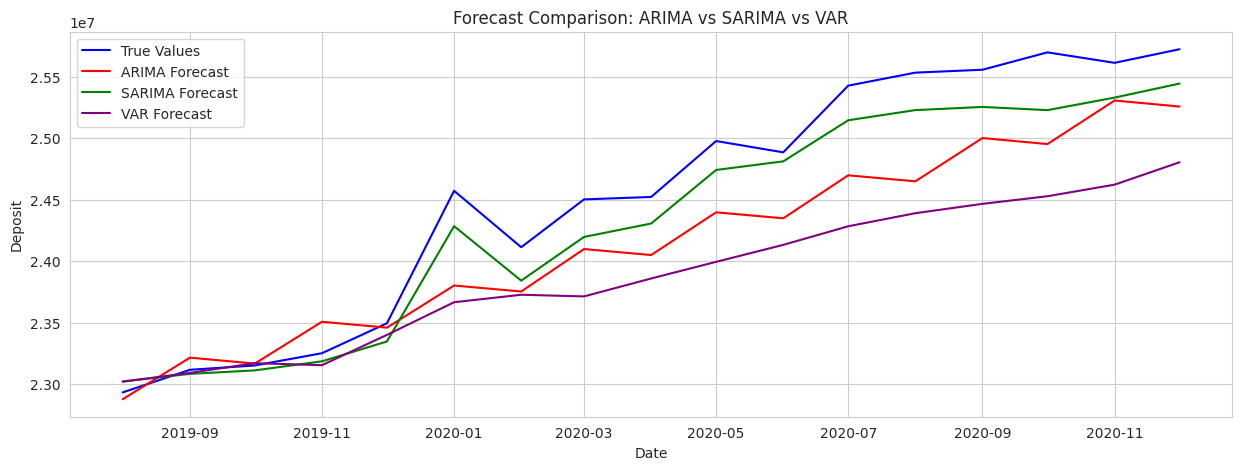

In [ ]:
# CODE 5

# Compare forecast quality for ARIMA/SARIMA/VAR models
# You can divided all data on two dataset (train and test)

# Преобразование Бокса-Кокса
data_var['deposit_rub_box'], lambda_param = stats.boxcox(data_var['Deposit_rub'])

# Разделение преобразованных данных на train и test
train_size_var = int(len(data_var) * 0.8)
train_data_var = data_var.iloc[:train_size_var]
test_data_var = data_var.iloc[train_size_var:]


# Прогноз для ARIMA модели
def forecast_arima(train, test, order):
    model = ARIMA(train, order=order).fit()
    forecast = model.forecast(steps=len(test))
    return forecast

# Прогноз для SARIMA модели
def forecast_sarima(train, test, order, seasonal_order):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order).fit(disp=False)
    forecast = model.forecast(steps=len(test))
    return forecast

# Прогноз для VAR модели
def forecast_var(train, test, maxlags):
    model = VAR(train)
    model_fit = model.fit(maxlags)
    forecast = model_fit.forecast(train.values, steps=len(test))
    return pd.DataFrame(forecast, index=test.index, columns=test.columns)


# Предсказание для ARIMA
arima_forecast_box = forecast_arima(train_data_var['deposit_rub_box'], test_data_var['deposit_rub_box'], order=(2, 1, 2))

# Предсказание для SARIMA
sarima_forecast_box = forecast_sarima(train_data_var['deposit_rub_box'], test_data_var['deposit_rub_box'], order=(0, 1, 0) , seasonal_order=(1, 1, [1], 12))

# Предсказание для VAR
var_forecast = forecast_var(train_data_var, test_data_var, maxlags=5)
var_forecast_deposit_rub_box = var_forecast['deposit_rub_box']

#  Оценка качества прогноза
arima_rmse_box = np.sqrt(mean_squared_error(test_data_var['deposit_rub_box'], arima_forecast_box))
sarima_rmse_box = np.sqrt(mean_squared_error(test_data_var['deposit_rub_box'], sarima_forecast_box))
var_rmse_box = np.sqrt(mean_squared_error(test_data_var['deposit_rub_box'], var_forecast_deposit_rub_box))

print(f"ARIMA RMSE (Box-Cox): {arima_rmse_box}")
print(f"SARIMA RMSE (Box-Cox): {sarima_rmse_box}")
print(f"VAR RMSE (Box-Cox): {var_rmse_box}")

# Инвертируем преобразование Бокса-Кокса для сравнения с исходными данными
def inverse_boxcox(y, lambda_param):
    if lambda_param != 0:
        return np.exp(np.log(lambda_param * y + 1) / lambda_param)
    else:
        return np.exp(y)

arima_forecast = inverse_boxcox(arima_forecast_box, lambda_param)
sarima_forecast = inverse_boxcox(sarima_forecast_box, lambda_param)
var_forecast_deposit_rub = inverse_boxcox(var_forecast_deposit_rub_box, lambda_param)

# Оценка качества прогноза по RMSE на исходных данных
arima_rmse = np.sqrt(mean_squared_error(test_data_var['Deposit_rub'], arima_forecast))
sarima_rmse = np.sqrt(mean_squared_error(test_data_var['Deposit_rub'], sarima_forecast))
var_rmse = np.sqrt(mean_squared_error(test_data_var['Deposit_rub'], var_forecast_deposit_rub))

print(f"ARIMA RMSE: {arima_rmse}")
print(f"SARIMA RMSE: {sarima_rmse}")
print(f"VAR RMSE: {var_rmse}")

# Визуальное сравнение прогнозов

plt.figure(figsize=(15, 5))
plt.plot(test_data_var.index, test_data_var['Deposit_rub'], label="True Values", color='blue')
plt.plot(test_data_var.index, arima_forecast, label="ARIMA Forecast", color='red')
plt.plot(test_data_var.index, sarima_forecast, label="SARIMA Forecast", color='green')
plt.plot(test_data_var.index, var_forecast_deposit_rub, label="VAR Forecast", color='purple')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Deposit")
plt.title("Forecast Comparison: ARIMA vs SARIMA vs VAR")
plt.show()


In [ ]:
# CODE 6

# Choose any addition financial time series.
# Calculate crosscorrelatioin/grangercausalitytests
# Add this time series to the model.
# Compare forecast quality.

In [ ]:
oil_data = pd.read_csv('neft-brent_quotes-mogus.csv', sep=";", encoding='utf-8')
oil_data['updated'] = pd.to_datetime(oil_data['updated'], dayfirst=True)
oil_data = oil_data.set_index('updated')
columns_to_drop = ['high', 'low', 'open', 'close', 'volume']
oil_data = oil_data.drop(columns=columns_to_drop, errors='ignore')
oil_data = oil_data.sort_index()
oil_data['updated'] = pd.to_datetime(oil_data.index, errors='coerce')

# Фильтруем данные с 2014 по 2020 год
oil_data_filtered = oil_data[(oil_data['updated'] >= '2014-01-01') & (oil_data['updated'] <= '2020-12-31')]

oil_data_filtered
oil_data_filtered['updated'] = pd.to_datetime(oil_data_filtered['updated'])
oil_data_filtered.set_index('updated', inplace=True)
oil_data_filtered['average'] = pd.to_numeric(oil_data_filtered['average'], errors='coerce')
oil_data_example_cleaned = oil_data_filtered.dropna()

# Ресемплинг по месяцам и расчет средней цены
oil_data_monthly_avg_cleaned = oil_data_example_cleaned.resample('M').mean()
oil_data_monthly_avg_cleaned
oil_data_monthly_avg_cleaned.index = oil_data_monthly_avg_cleaned.index.to_period('M').to_timestamp()

data_var_combined = pd.concat([data_var, oil_data_monthly_avg_cleaned], axis=1)

data_var_combined.head()


,Deposit_rub,Inflation,USDRUB,wage,average
2014-01-01,14000569.0,0.34,33.784118,29535,106.978000
2014-02-01,13433121.0,0.59,35.244500,29255,108.428958
2014-03-01,13510318.0,0.99,36.199000,31486,107.675385
2014-04-01,13206977.0,0.88,35.667727,32947,108.068400
2014-05-01,13507416.0,0.94,34.834500,32272,108.933600


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

# Выполняем тест причинности Грейнджера для определения взаимосвязи между ценами на нефть и переменными в `data_var`
granger_test = grangercausalitytests(data_var_combined[['Deposit_rub', 'average']].dropna(), maxlag=5, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3958  , p=0.5310  , df_denom=80, df_num=1
ssr based chi2 test:   chi2=0.4107  , p=0.5216  , df=1
likelihood ratio test: chi2=0.4097  , p=0.5221  , df=1
parameter F test:         F=0.3958  , p=0.5310  , df_denom=80, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0835  , p=0.0515  , df_denom=77, df_num=2
ssr based chi2 test:   chi2=6.5675  , p=0.0375  , df=2
likelihood ratio test: chi2=6.3177  , p=0.0425  , df=2
parameter F test:         F=3.0835  , p=0.0515  , df_denom=77, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5551  , p=0.2075  , df_denom=74, df_num=3
ssr based chi2 test:   chi2=5.1068  , p=0.1641  , df=3
likelihood ratio test: chi2=4.9523  , p=0.1753  , df=3
parameter F test:         F=1.5551  , p=0.2075  , df_denom=74, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4221  , p=0.2355  , df_d

На лаге 2 , результаты теста (p≈0.0515 для F-теста) указывают на возможное наличие причинно-следственной связи между ценами на нефть и Deposit_rub, но эта связь не является достаточно статистически значимой (на уровне 95% доверия).
На всех остальных лагах , значения p высокие (больше 0.05), что указывает на отсутствие доказательств причинно-следственной связи на этих лагах.

In [ ]:
# Разделяем данные на обучающую и тестовую выборки
train_size = int(len(data_var_combined) * 0.8)
train_data_var = data_var_combined.iloc[:train_size]
test_data_var = data_var_combined.iloc[train_size:]


VAR RMSE with Oil Prices: 614355.5684426095


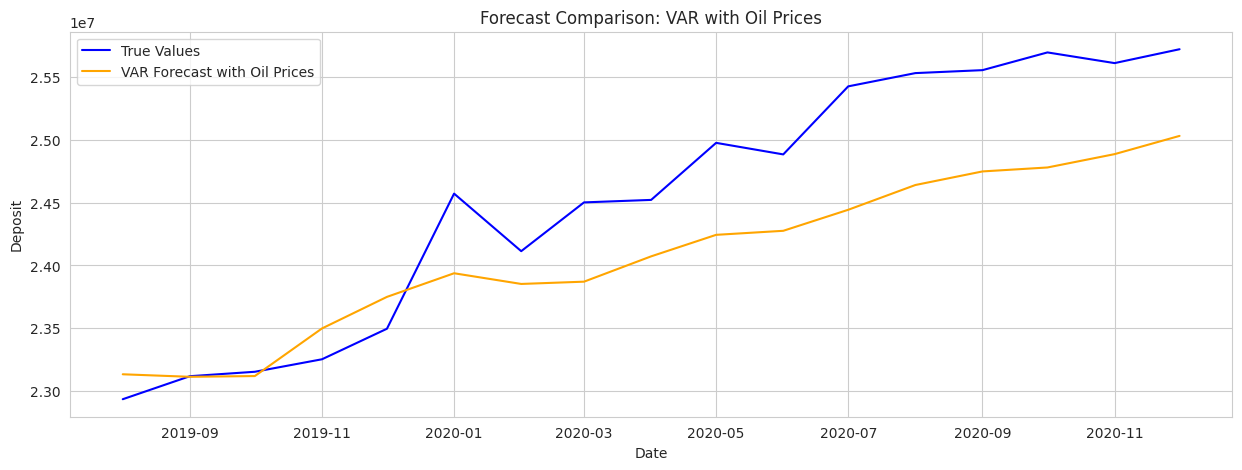

In [ ]:
# Функция для обучения модели VAR и прогнозирования
def forecast_var(train, test, maxlags):
    model = VAR(train)
    model_fit = model.fit(maxlags)
    forecast = model_fit.forecast(train.values, steps=len(test))
    return pd.DataFrame(forecast, index=test.index, columns=train.columns)

# Обучение модели VAR с учетом временного ряда нефти
var_forecast_with_oil = forecast_var(train_data_var, test_data_var, maxlags=5)

# Сравниваем прогнозы для переменной 'Deposit_rub'
var_forecast_deposit_rub_with_oil = var_forecast_with_oil['Deposit_rub']

# Оценка качества прогноза по RMSE
var_rmse_with_oil = np.sqrt(mean_squared_error(test_data_var['Deposit_rub'], var_forecast_deposit_rub_with_oil))

print(f"VAR RMSE with Oil Prices: {var_rmse_with_oil}")

# Визуальное сравнение прогнозов
plt.figure(figsize=(15, 5))
plt.plot(test_data_var.index, test_data_var['Deposit_rub'], label="True Values", color='blue')
plt.plot(test_data_var.index, var_forecast_deposit_rub_with_oil, label="VAR Forecast with Oil Prices", color='orange')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Deposit")
plt.title("Forecast Comparison: VAR with Oil Prices")
plt.show()


Судя по RMSE качество прогноза улучшилось с добавлением информации о средней цене нефти за месяц.